In [2]:
library(dplyr)
library(repr)
library(rstan)
library(bayesplot)  # Used for mcmc_trace/mcmc_hist
library(ggplot2)
library(patchwork)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: StanHeaders


rstan version 2.32.7 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


This is bayesplot version 1.14.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting



# DATASET EXTRACTION

In [3]:
dataset_Auronzo <- read.csv("dataset/Auronzo.csv", header = FALSE, sep = ";") # nolint # nolint
head(dataset_Auronzo, n = 10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ARPAV Centro Meteorologico di Teolo,,,,,,,,,,,,,
2,,,,,,,,,,,,,,
3,Bollettino dei valori mensili pluriennali,,,,,,,,,,,,,
4,,,,,,,,,,,,,,
5,Stazione Auronzo,,,,,,,,,,,,,
6,Coordinata X 1762629 Gauss-Boaga fuso,,,,,,,,,,,,,
7,Coordinata Y 5161582 Ovest (EPSG:3003),,,,,,,,,,,,,
8,Quota della stazione 849 m s.l.m.,,,,,,,,,,,,,
9,Parametro Precipitazione (mm) somma,,,,,,,,,,,,,


In [4]:
extract_dataset <- function(directory, city_list) {
    
    convert_numbers <- function(x) {
      num <- suppressWarnings(as.numeric(x))
      ifelse(is.na(num) & !is.na(x), x, num)
    }

    clean_text <- function(x) {
      if (is.character(x)) {
        iconv(x, from = "", to = "UTF-8", sub = "_")
      } else {
        x
      }
    }
    
    dataset <- list()
    months <- c('GEN', 'FEB', 'MAR', 'APR', 'MAG', 'GIU', 'LUG', 'AGO', 'SET', 'OTT', 'NOV', 'DIC')
    
    for (city in city_list) {
        dataset_city <- read.csv(paste0(directory, "/", city, ".csv"), header = FALSE, sep = ";", stringsAsFactors = FALSE)
        dataset_city[] <- lapply(dataset_city, clean_text)
        extracted_ds <- list()
        
        for (n_line in 1:nrow(dataset_city)) {

            element = dataset_city[n_line, 1]

            if (startsWith(element, "Parametro")) {

                metric <- substr(element, nchar("Parametro ")+1, nchar(element))
                metric <- iconv(metric, from = "", to = "UTF-8", sub = "_")
                
                data_matrix <- as.matrix(sapply(dataset_city[(n_line + 5):(n_line + 35), 2:13], convert_numbers))
                skipped_days_matrix <- as.matrix(sapply(dataset_city[(n_line + 48):(n_line + 78), 2:13], convert_numbers))
                
                n_rows <- min(nrow(data_matrix), nrow(skipped_days_matrix))
                years <- 1994:(1994 + n_rows - 1)
                
                data_matrix <- data_matrix[1:n_rows, , drop = FALSE]
                skipped_days_matrix <- skipped_days_matrix[1:n_rows, , drop = FALSE]
                
                rownames(data_matrix) <- years
                rownames(skipped_days_matrix) <- years
                colnames(data_matrix) <- months[1:ncol(data_matrix)]
                colnames(skipped_days_matrix) <- months[1:ncol(skipped_days_matrix)]
                
                extracted_ds[[metric]] <- data_matrix
                extracted_ds[[paste0(metric, "_days")]] <- skipped_days_matrix
            }

        }
            
        dataset[[city]] <- extracted_ds
    }
        
    return(dataset)
}


In [5]:
stations_names <- c("Auronzo", "Porto_Tolle_-_Pradon", "Roverchiara", "Castelfranco_Veneto")

In [6]:
dataset <- extract_dataset("dataset", stations_names)

In [7]:
# dataset

In [8]:
#Printout the schema of the df
glimpse(dataset)

List of 4
 $ Auronzo             :List of 20
  ..$ Precipitazione (mm) somma                                  : num [1:31, 1:12] 56.4 37.8 28.6 51.2 24.4 ...
  .. ..- attr(*, "dimnames")=List of 2
  ..$ Precipitazione (mm) somma_days                             : num [1:31, 1:12] 2 0 0 0 0 0 0 0 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  ..$ Precipitazione (giorni piovosi)                            : num [1:31, 1:12] 7 7 7 7 7 5 1 11 1 5 ...
  .. ..- attr(*, "dimnames")=List of 2
  ..$ Precipitazione (giorni piovosi)_days                       : num [1:31, 1:12] 2 0 0 0 0 0 0 0 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  ..$ Radiazione solare globale (MJ/m2)                          : num [1:31, 1:12] 108 131 110 123 146 ...
  .. ..- attr(*, "dimnames")=List of 2
  ..$ Radiazione solare globale (MJ/m2)_days                     : chr [1:31, 1:12] "0" "0" "0" "0" ...
  .. ..- attr(*, "dimnames")=List of 2
  ..$ Temperatura aria a 2m (_C) media delle minime              : num 

In [9]:
# Lista delle metriche del dataset

metrics_list <- names(dataset[["Auronzo"]])
print(metrics_list)

 [1] "Precipitazione (mm) somma"                                  
 [2] "Precipitazione (mm) somma_days"                             
 [3] "Precipitazione (giorni piovosi)"                            
 [4] "Precipitazione (giorni piovosi)_days"                       
 [5] "Radiazione solare globale (MJ/m2)"                          
 [6] "Radiazione solare globale (MJ/m2)_days"                     
 [7] "Temperatura aria a 2m (_C) media delle minime"              
 [8] "Temperatura aria a 2m (_C) media delle minime_days"         
 [9] "Temperatura aria a 2m (_C) media delle medie"               
[10] "Temperatura aria a 2m (_C) media delle medie_days"          
[11] "Temperatura aria a 2m (_C) media delle massime"             
[12] "Temperatura aria a 2m (_C) media delle massime_days"        
[13] "Umidit_ relativa a 2m (%) minima delle minime"              
[14] "Umidit_ relativa a 2m (%) minima delle minime_days"         
[15] "Umidit_ relativa a 2m (%) massima delle massime"        

In [10]:
dataset[["Auronzo"]][["Temperatura aria a 2m (_C) media delle medie"]]

,GEN,FEB,MAR,APR,MAG,GIU,LUG,AGO,SET,OTT,NOV,DIC
1994,-2.2,-1.6,5.5,5.9,11.9,14.8,17.5,17.5,13.1,6.7,4.0,-1.8
1995,-5.2,-0.1,1.3,6.9,11.0,13.2,18.2,15.0,10.6,8.0,1.5,-2.3
1996,-1.8,-3.3,1.1,7.2,11.7,15.8,16.1,15.0,9.7,6.9,2.4,-2.5
1997,-1.6,-0.6,4.4,5.5,11.5,14.5,15.4,16.3,13.7,7.1,2.5,-1.3
1998,-3.0,0.2,2.7,6.3,11.8,15.7,17.1,17.1,11.8,6.8,-0.3,-3.8
1999,-4.2,-2.4,2.7,7.2,12.9,14.4,16.9,16.7,13.7,7.9,0.1,-4.5
2000,-5.8,-0.7,3.5,8.4,13.0,16.3,15.2,17.0,12.8,8.8,2.9,-1.0
2001,-1.8,-0.3,4.7,5.5,13.4,14.4,16.9,17.4,9.8,9.4,0.0,-5.5
2002,-5.1,0.2,4.6,6.8,12.0,17.0,17.2,15.9,11.2,7.4,4.1,-0.5
2003,-3.7,-4.3,4.0,6.2,13.2,18.2,17.9,18.6,11.2,5.1,2.1,-2.5


# Part 0

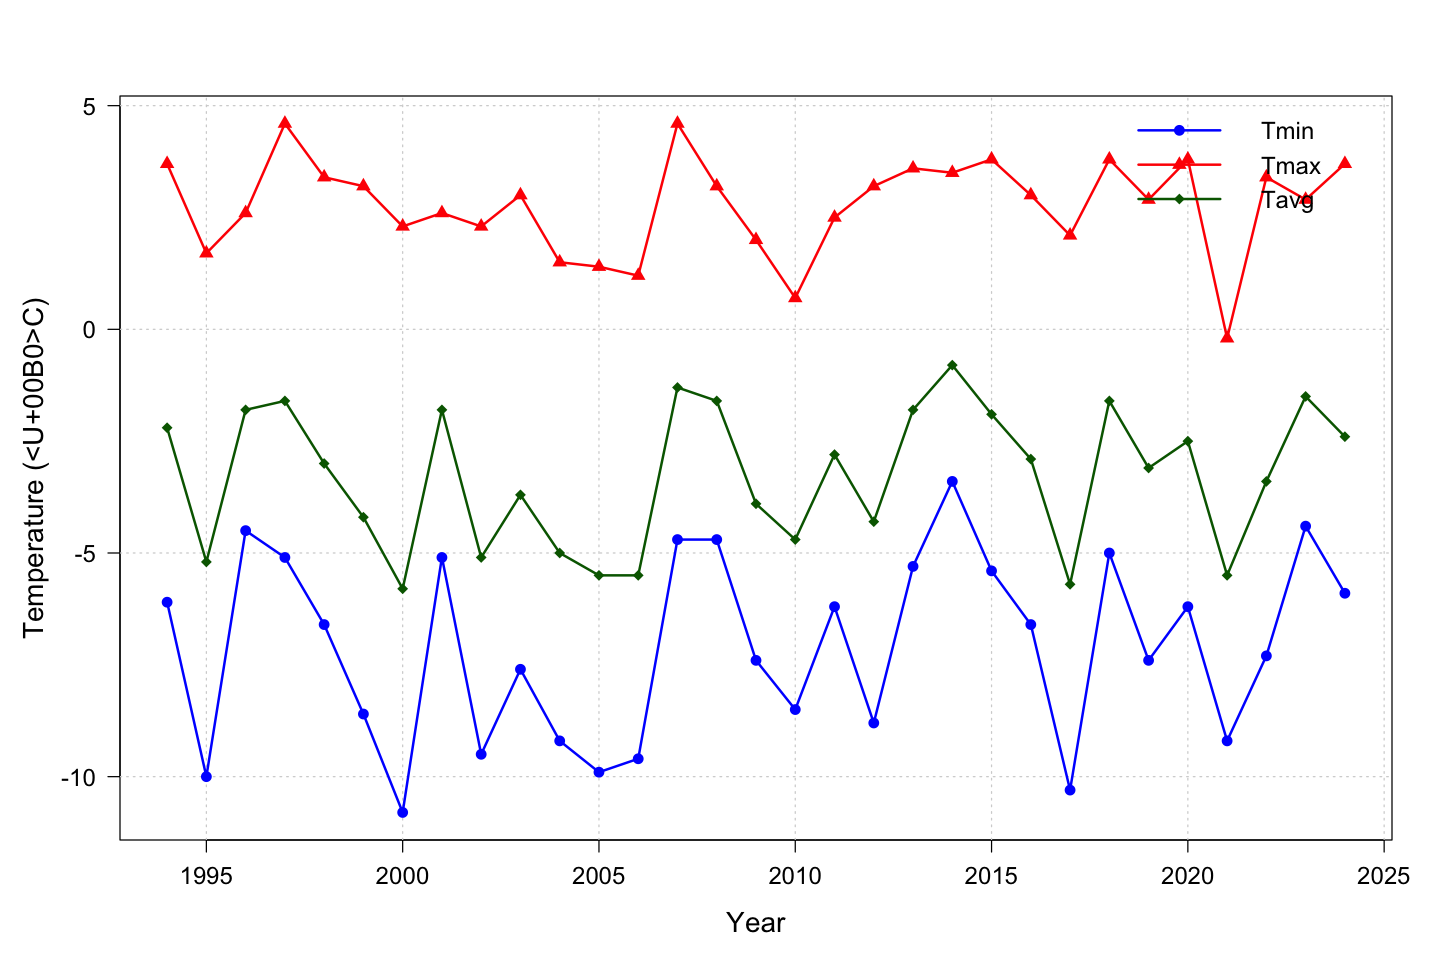

In [11]:
# Cambia size dell'immagine
options(repr.plot.width=12, repr.plot.height=8)

Tmin_gen <- dataset[["Auronzo"]][["Temperatura aria a 2m (_C) media delle minime"]][,"GEN"]
Tmax_gen <- dataset[["Auronzo"]][["Temperatura aria a 2m (_C) media delle massime"]][,"GEN"]
Tmean_gen <- dataset[["Auronzo"]][["Temperatura aria a 2m (_C) media delle medie"]][,"GEN"]

Tmin_gen <- suppressWarnings(as.numeric(Tmin_gen))
Tmax_gen <- suppressWarnings(as.numeric(Tmax_gen))

n <- min(length(Tmin_gen), length(Tmax_gen))
Tmin_gen <- Tmin_gen[1:n]
Tmax_gen <- Tmax_gen[1:n]
years <- 1994:(1994 + n - 1)

valid_idx <- !is.na(Tmin_gen) & !is.na(Tmax_gen)
years <- years[valid_idx]
Tmin_gen <- Tmin_gen[valid_idx]
Tmax_gen <- Tmax_gen[valid_idx]

# Imposta margini e dimensioni del testo
par(mar = c(5, 5, 4, 2), cex.axis = 1.2, cex.lab = 1.4, cex.main = 1.5, bg = "white")

# Plot vuoto con più spazio e più grande
plot(years, Tmin_gen, type = "n", 
     ylim = range(c(Tmin_gen, Tmax_gen)), 
     xlab = "Year", ylab = "Temperature (°C)", 
     las = 1, cex = 1.2, cex.lab = 1.4, cex.axis = 1.2)

# Aggiungi griglia leggera
grid(col = "lightgray", lty = "dotted")

# Linee
lines(years, Tmin_gen, col = "blue", lwd = 2)
lines(years, Tmax_gen, col = "red", lwd = 2)
lines(years, Tmean_gen, col = "darkgreen", lwd = 2)

# Punti
points(years, Tmin_gen, col = "blue", pch = 16, cex = 1.2)
points(years, Tmax_gen, col = "red", pch = 17, cex = 1.2)
points(years, Tmean_gen, col = "darkgreen", pch = 18, cex = 1.2)

# Legenda migliorata
legend("topright", legend = c("Tmin", "Tmax", "Tavg"),
       col = c("blue", "red", "darkgreen"), 
       lty = 1, pch = c(16, 17, 18),
       lwd = 2, bty = "n", cex = 1.2)

# Part 1

## Linear regression

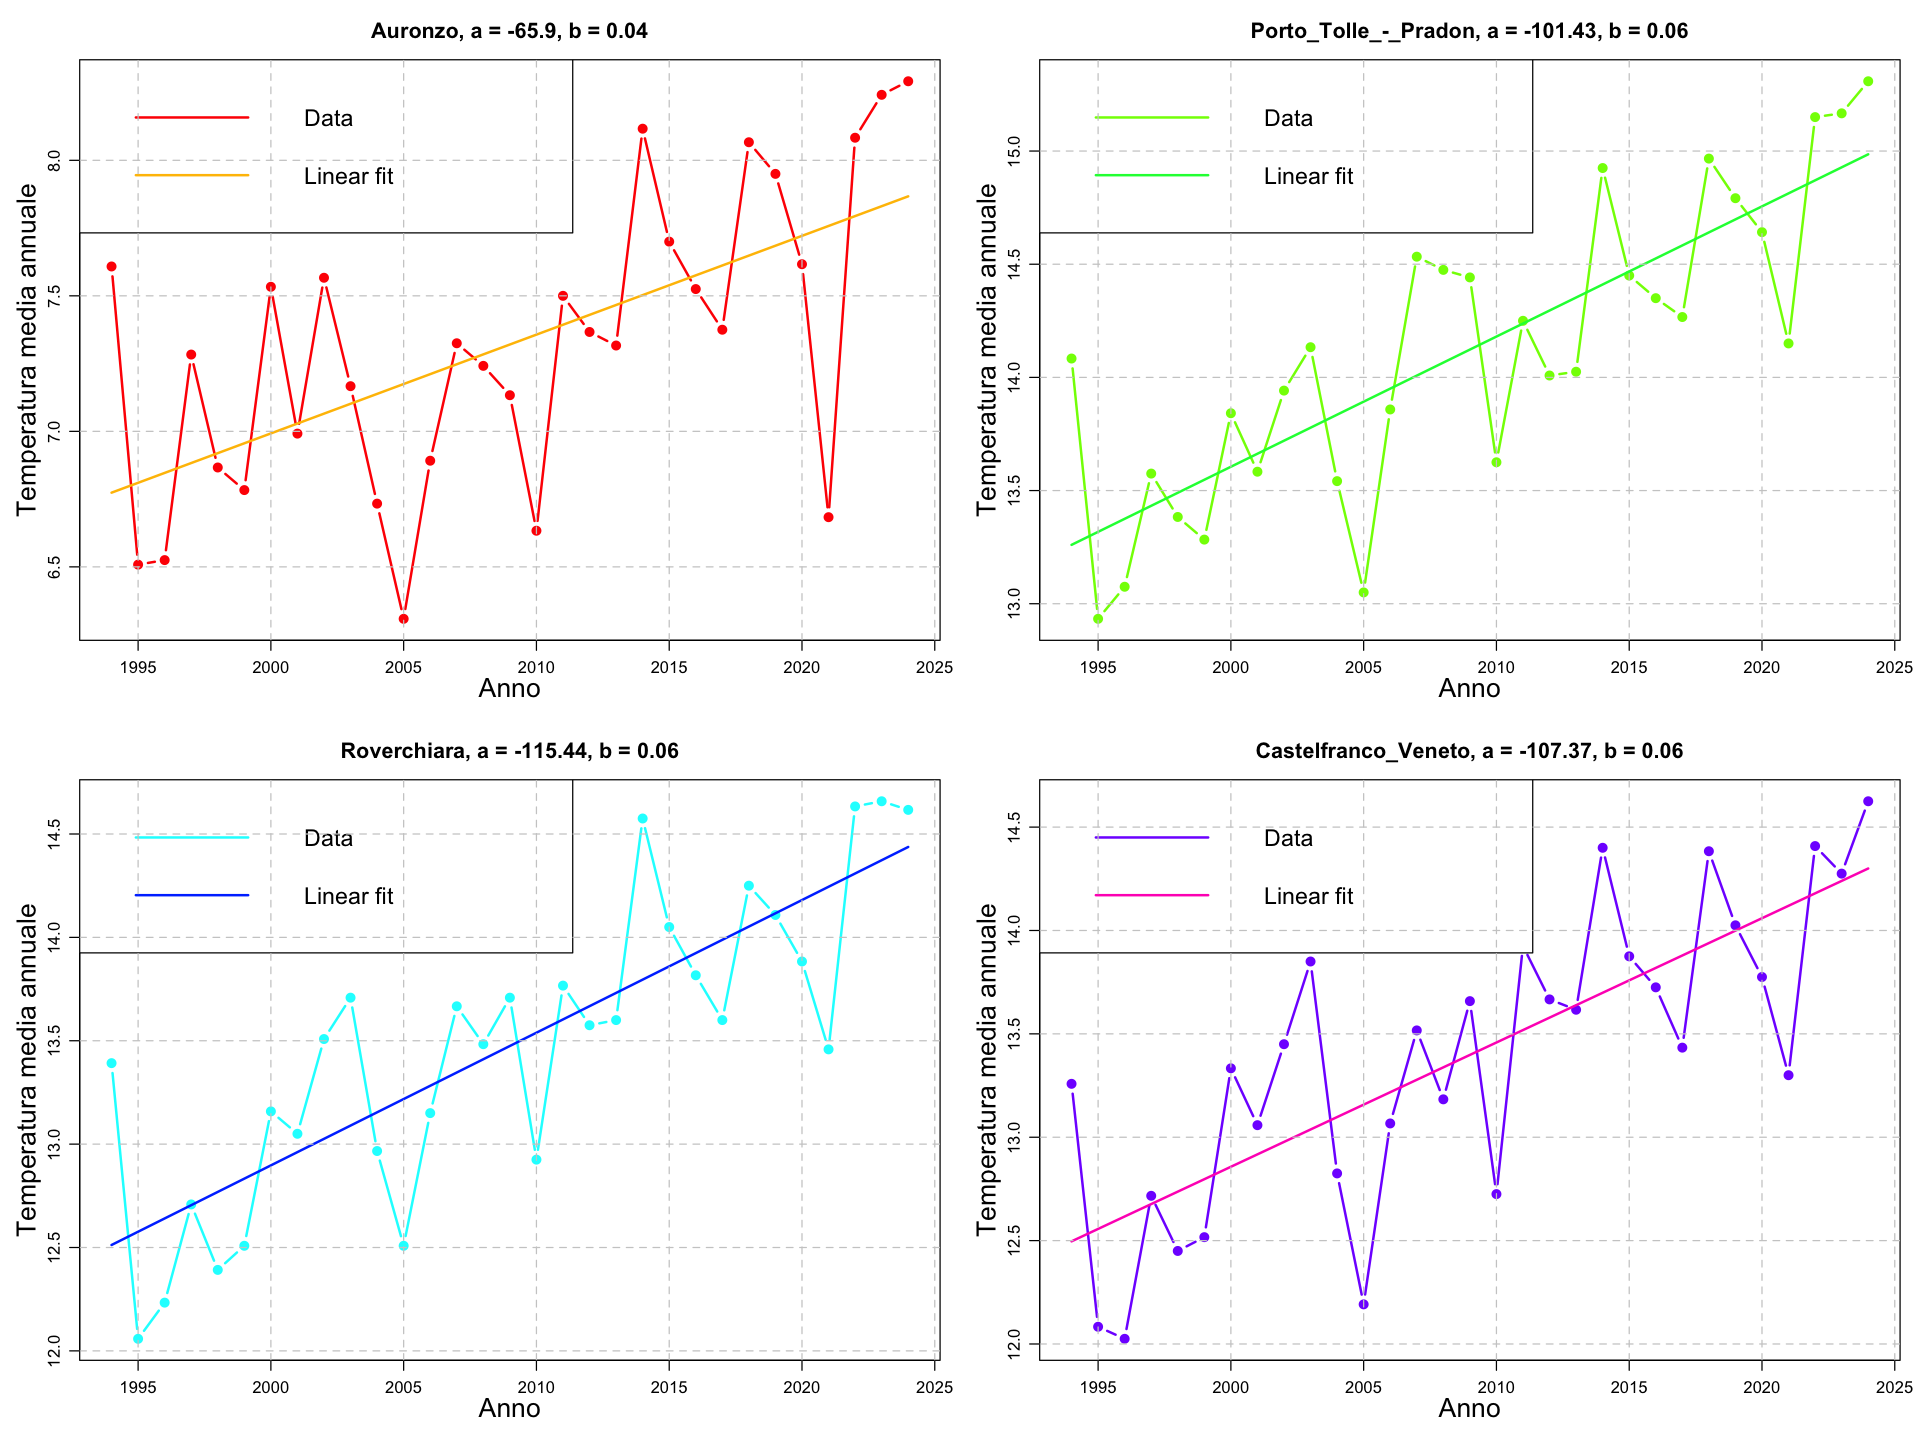

In [12]:
options(repr.plot.width=16, repr.plot.height=12)

years <- 1994:2024
par(mfrow = c(2,2), bg = "white", mar=c(4,4,3,1)) 
par(mgp = c(2, 0.8, 0))

# Color palette 
colors <- rainbow(length(stations_names)*2)

models <- list()

for (i in seq(1, length(stations_names))) {
    name <- stations_names[i]
    
    # Compute average over months
    annual_average <- rowMeans(dataset[[name]][["Temperatura aria a 2m (_C) media delle medie"]])

    # Linear fit
    lin_model <- lm(annual_average ~ years)
    annual_average_model <- predict(lin_model)
    coeffs <- lin_model$coefficients
    models[[name]] <- lin_model
    
    # Plots
    plot(years, annual_average, type="b", pch=19, col=colors[2*i-1],
         lwd=2, cex.lab=1.6,
         main=paste0(name, ", a = ", round(coeffs[1], 2), ", b = ", round(coeffs[2], 2)),
         font.main=2, cex.main=1.3,
         xlab="Anno", ylab="Temperatura media annuale")
    

    lines(years, annual_average_model, col=colors[2*i], lwd=2)

    legend(
        'topleft',
        legend=c("Data", "Linear fit"),
        col=c(colors[2*i-1], colors[2*i]),
        lwd=c(2, 2),
        cex=1.4
        )
    
    grid(col="gray80", lty=2) 

}

## Bayesian regression with STAN

Bayesian linear regression between temperature $T$ and year $y$: $$ T_i \sim Norm(a+y_i*b, \sigma). $$
Constant regression between $T$ and $y$ (i.e. temperature is independant of the year): $$ T_i \sim Norm(\mu, \sigma). $$

In [ ]:
stan_regression <- function(model, iterations, n_chains=3, warmup=200) {
    
    ################################
    #
    # Plots MCMC for parameters of the chosen model and outputs best values of such parameters, given by the average of the MCMC final values.
    #
    # PARAMETERS:
    # model: 'linear', 'const'
    # iterations: number of steps of the chain
    # warmup: number of neglected initial steps
    #
    ################################
    
    # Picks the file in which the model is contained
    models_list <- list(
        const = "constant_model.stan",
        linear = "linear_model.stan"
    )

    params_list <- list(
        const = c("k", "sigma"),
        linear = c("a", "b", "sigma")
    )

    options(repr.plot.width=12, repr.plot.height=8)

    best_values = list()

    # Create Dynamic shared object
    stan_DSO <- stan_model(file = models_list[[model]])
    params   <- params_list[[model]]

    for (name in stations_names) {
        lin_model <- models[[name]]

        # Create data list for Stan sampling
        annual_average <- rowMeans(dataset[[name]][["Temperatura aria a 2m (_C) media delle medie"]])
        N              <- length(years)

        # Depending on the model we have different datasets and initializations
        if (model == 'linear') {

            data_list <- list(N = N, years = years, avg_temp = annual_average)
            data_init <- list(a = lin_model$coefficients[[1]], b = lin_model$coefficients[[2]], sigma = 0.5)

        } else if (model == 'const') {

            data_list <- list(N = N, avg_temp = annual_average)
            data_init <- list(k = mean(annual_average), sigma = 0.5)

        }

        # Generate MCMC
        suppressWarnings({
            stan_fit <- sampling(
                object = stan_DSO,
                data = data_list,
                chains = n_chains,
                iter = iterations,
                warmup = warmup,
                init = rep(list(data_init), n_chains),
                show_messages = FALSE, # Suppress messages
                refresh = 0            # Suppress progress lines
            )
        })

        # Plot Markov chain from Stan fit
        trace_plot <-  (
            mcmc_trace(stan_fit, pars = params) + 
            theme(
                axis.title = element_text(size = 18),   
                axis.text = element_text(size = 14),    
                strip.text = element_text(size = 15, face = "bold")
            )
        )
 
        # Plot histogram 
        hist_plot <- (
            mcmc_hist(stan_fit, pars = params, bins = floor(sqrt(iterations))) +
            theme(
                axis.title = element_text(size = 18),
                axis.text = element_text(size = 14),
                strip.text = element_text(size = 15, face = "bold") 
            )
        )
        
        print(trace_plot/hist_plot)

        # Get data from MCMCM and compute best values
        MCMC_data <- as.data.frame(stan_fit)
        best_values[[name]] <- colMeans(MCMC_data)
    }

    return(best_values)
}

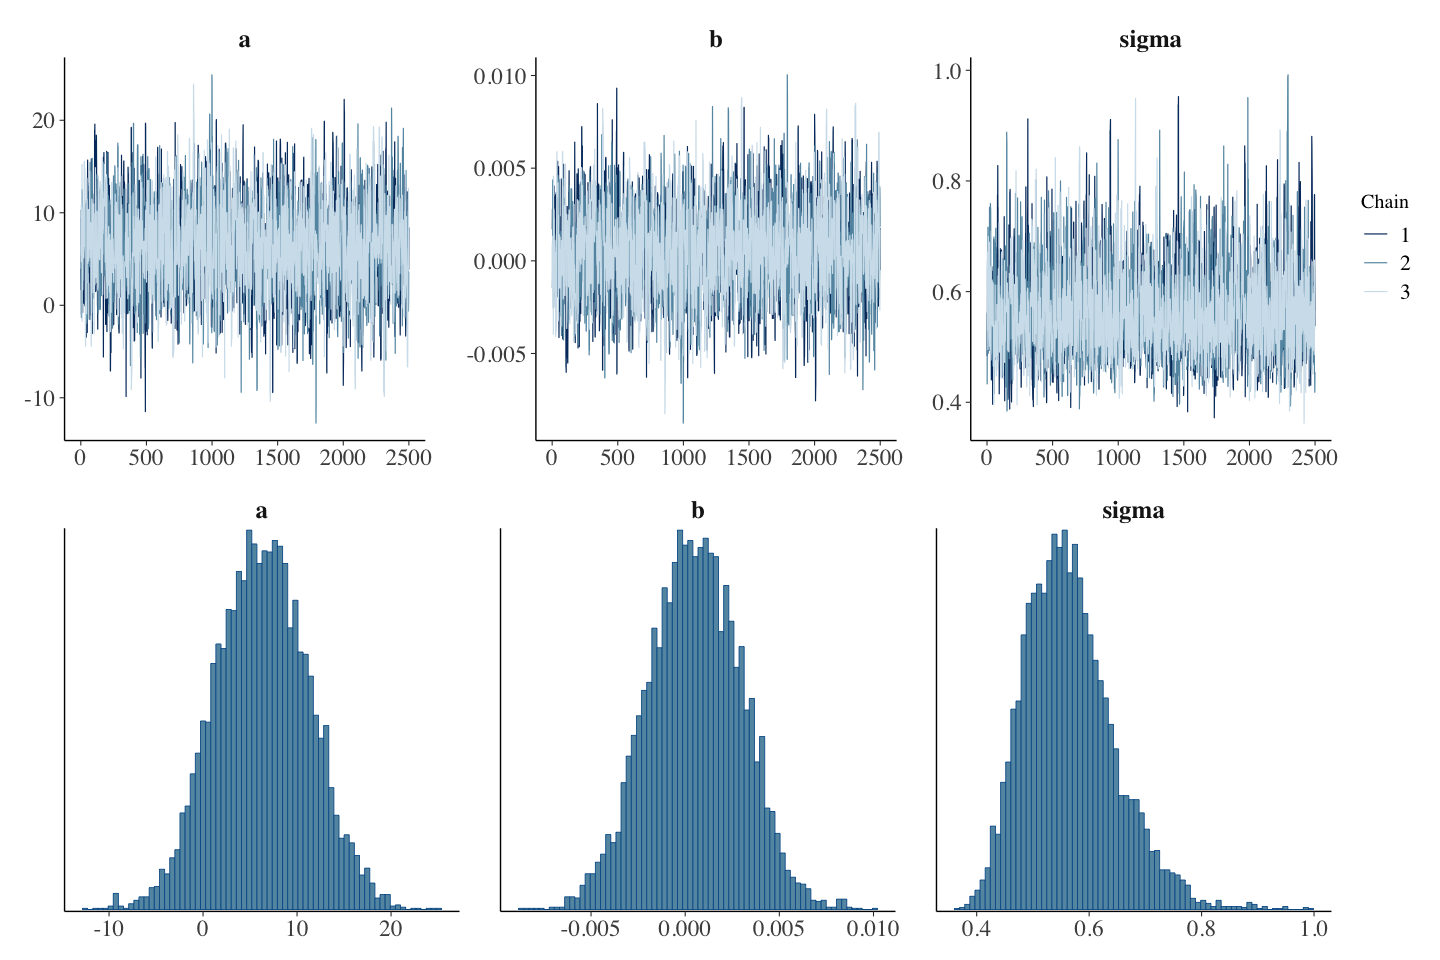

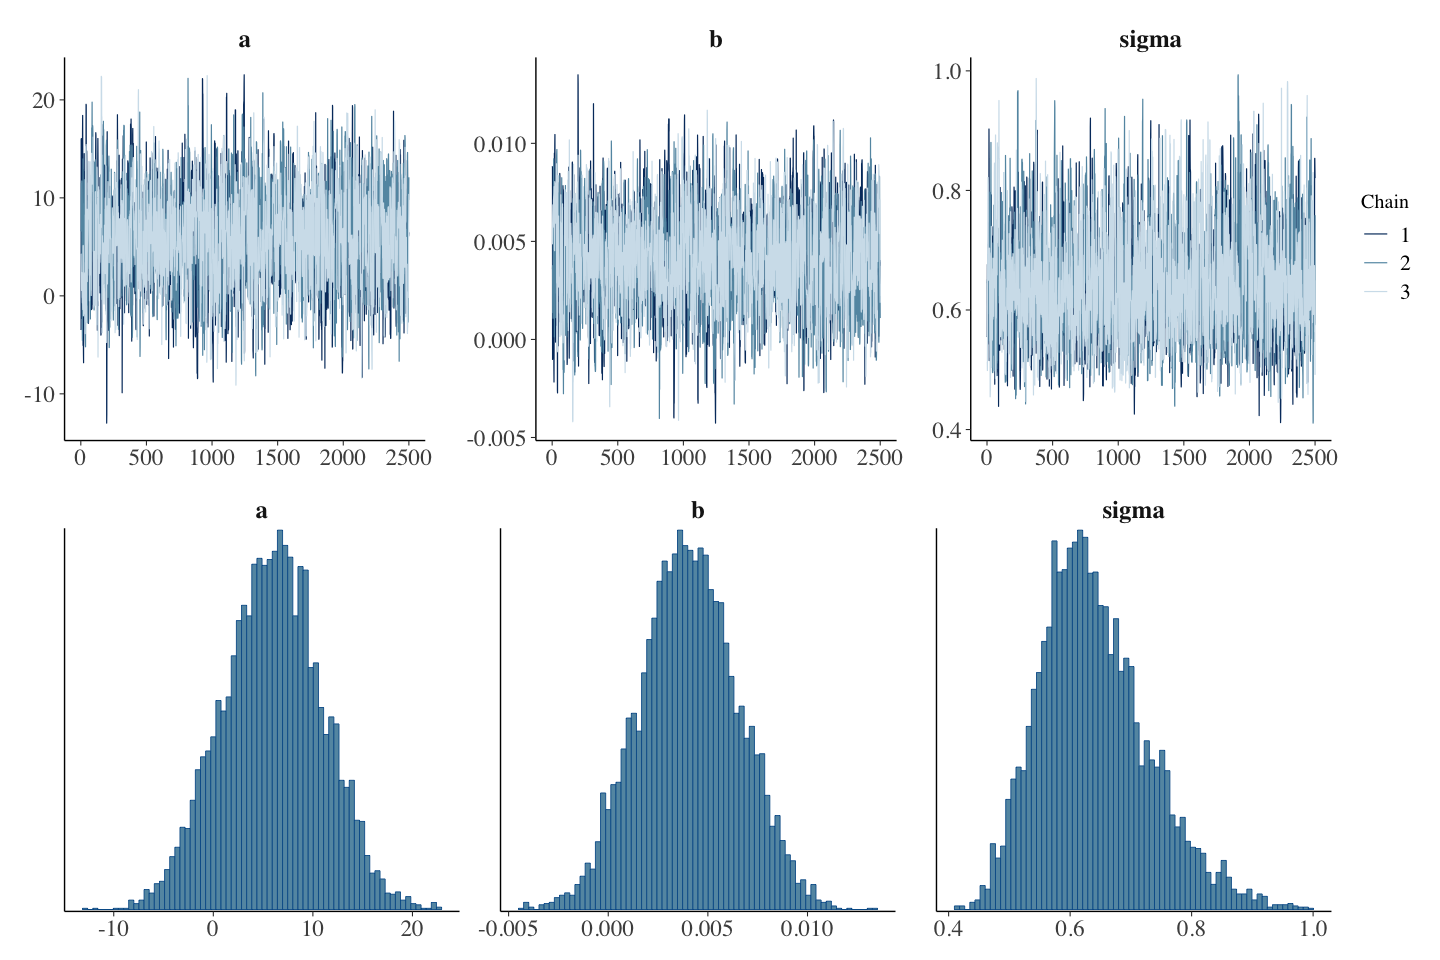

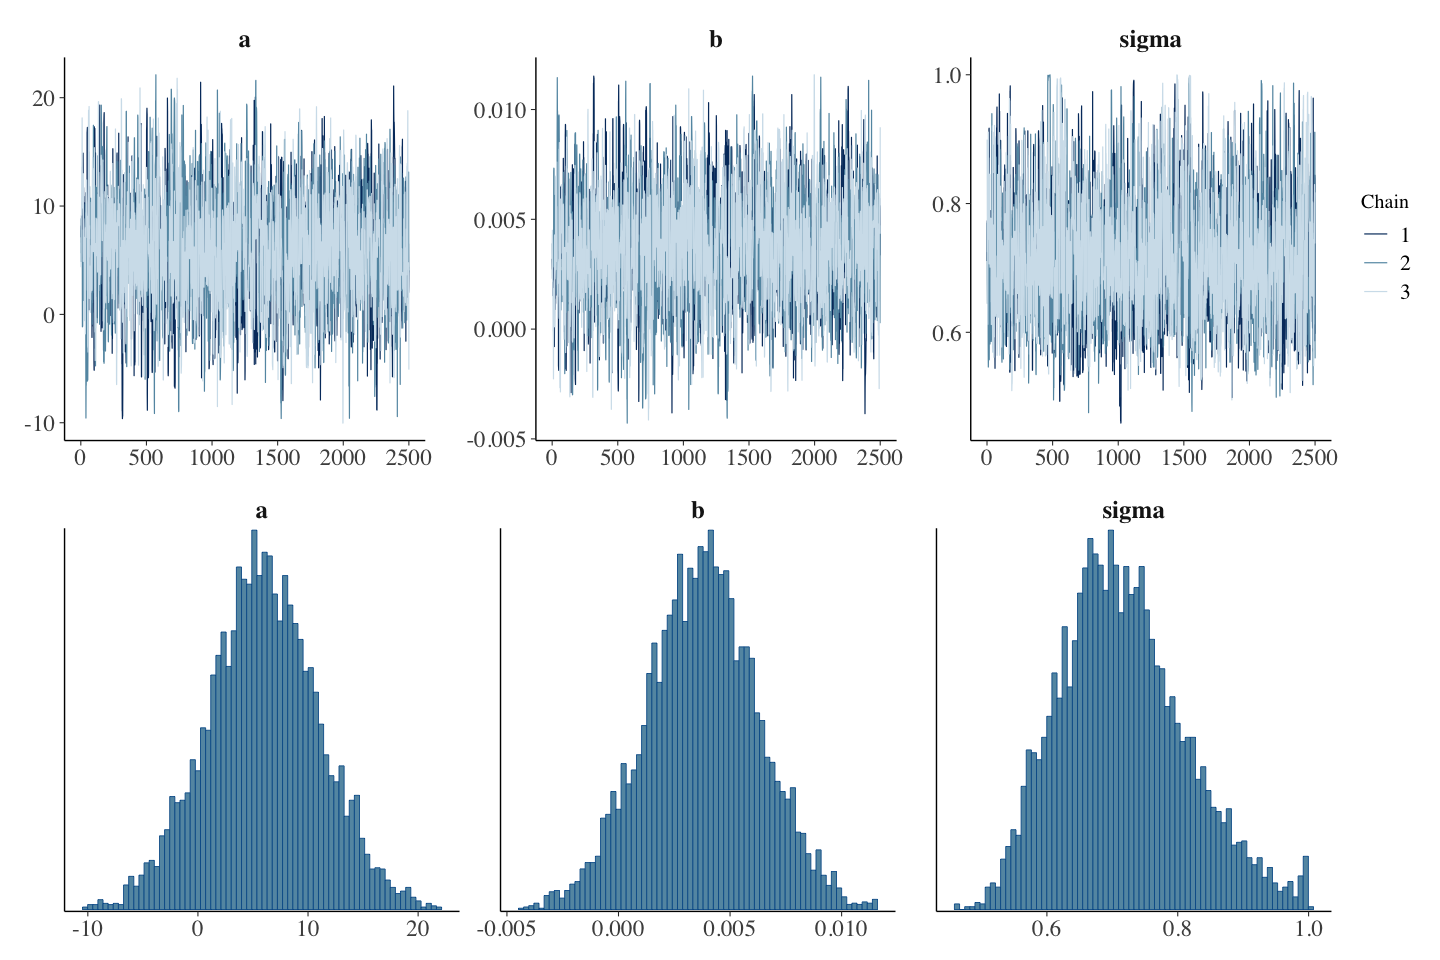

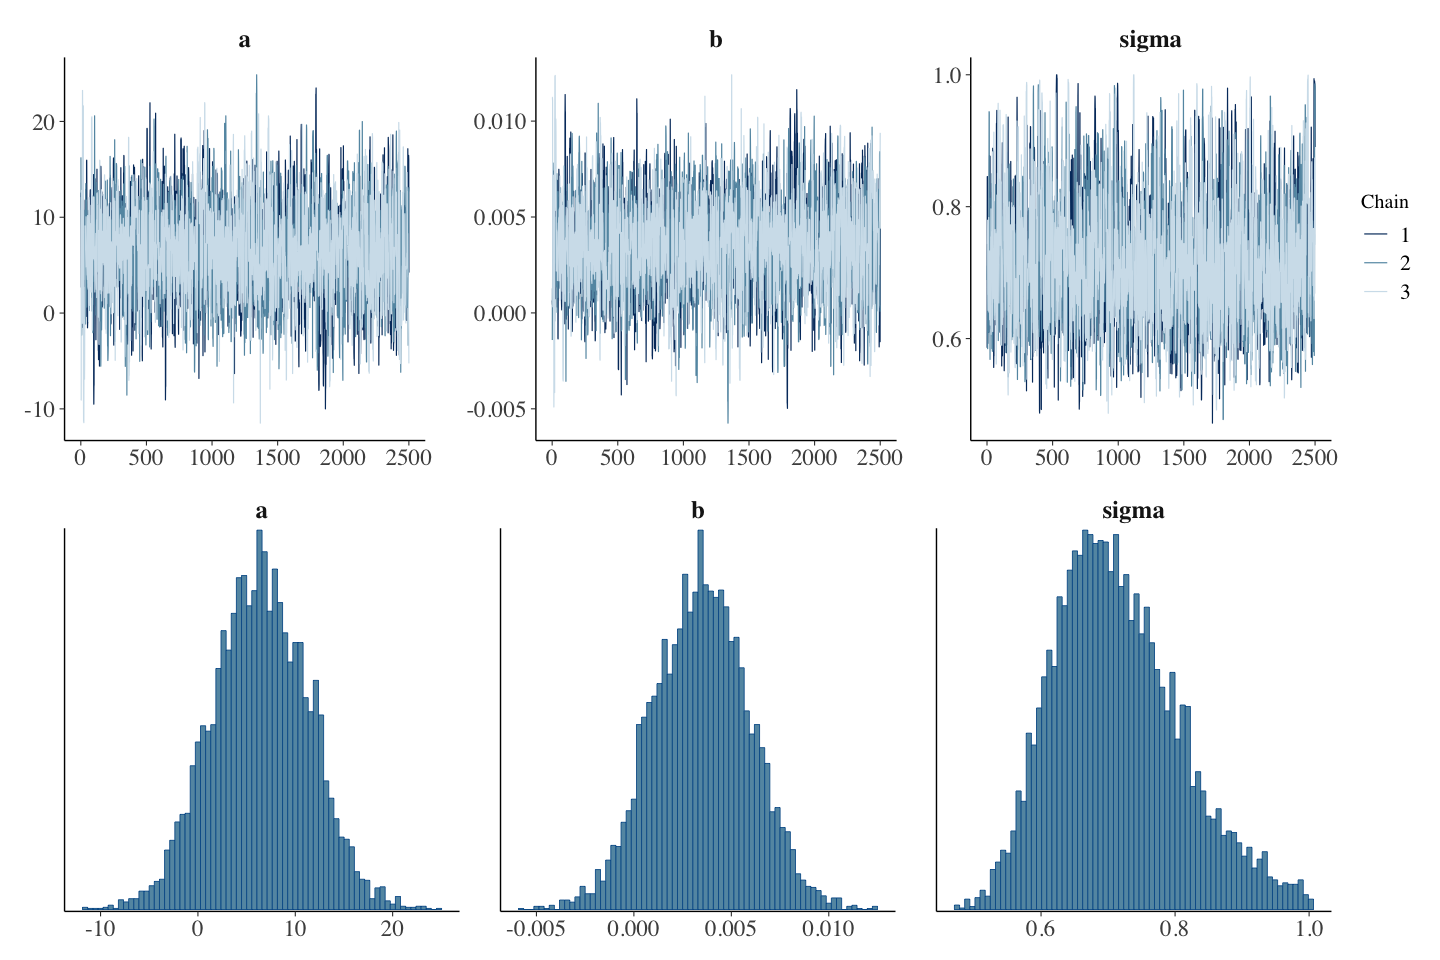

In [14]:
iterations <- 5e3
linear_best_val <- stan_regression('linear', iterations, warmup=iterations/2, n_chains=3)

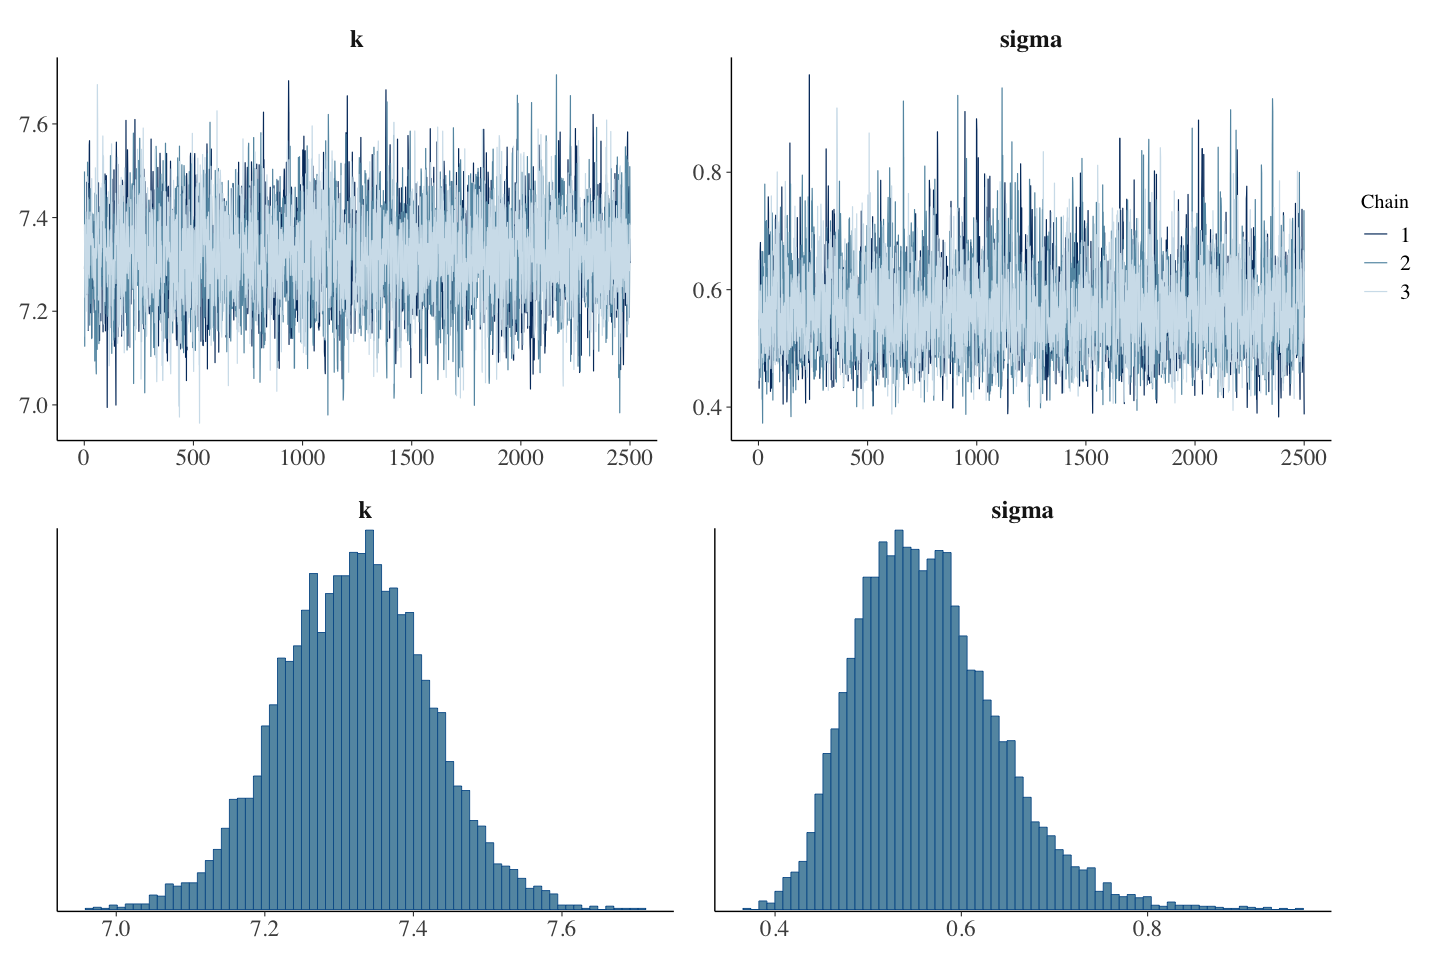

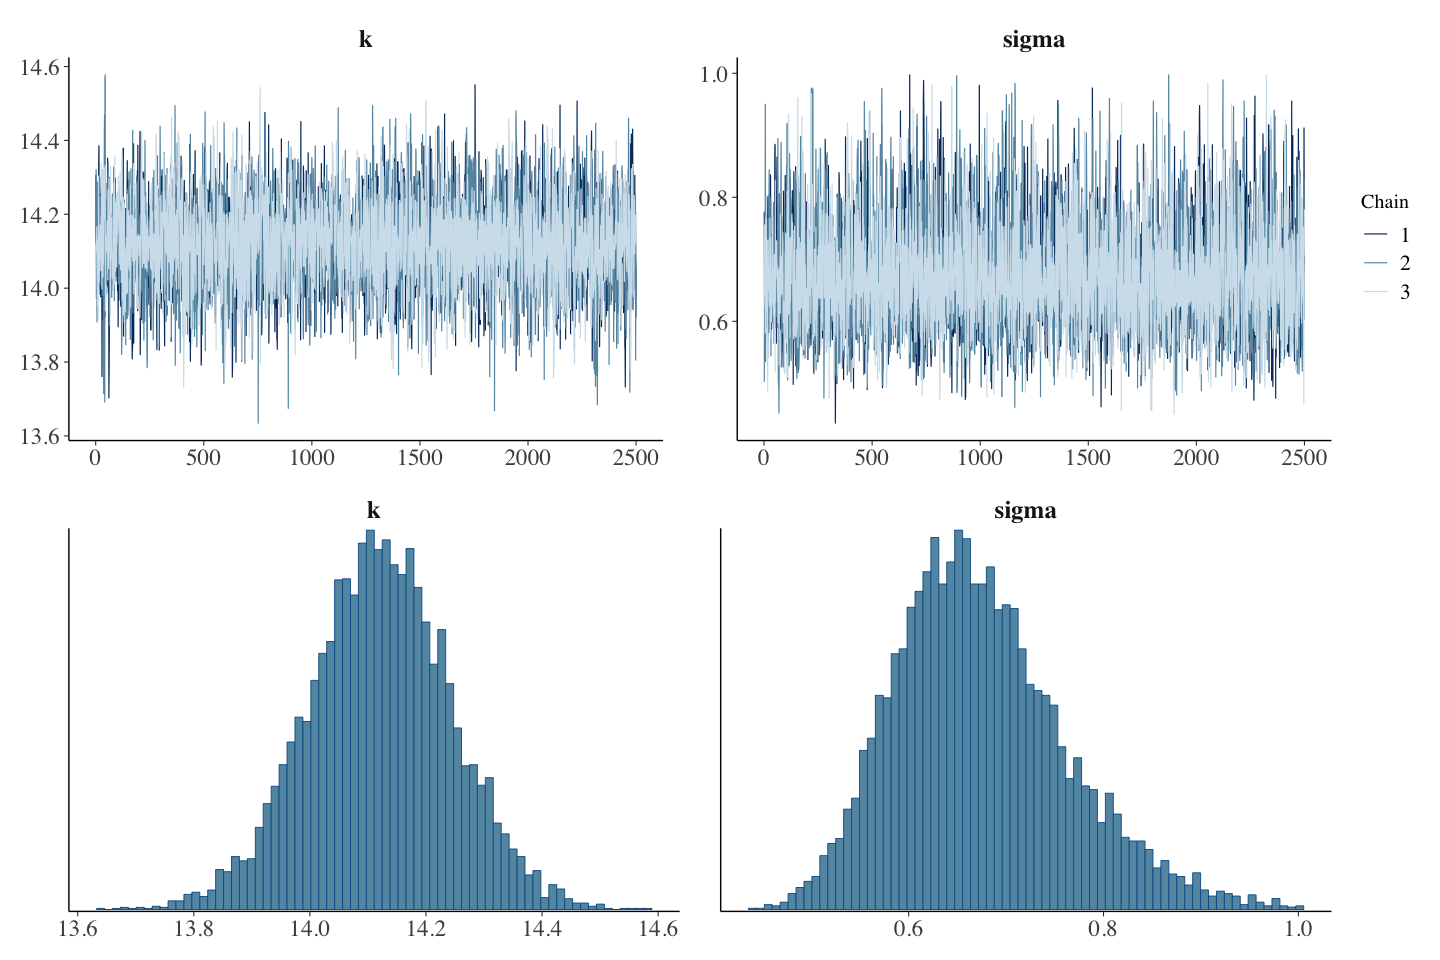

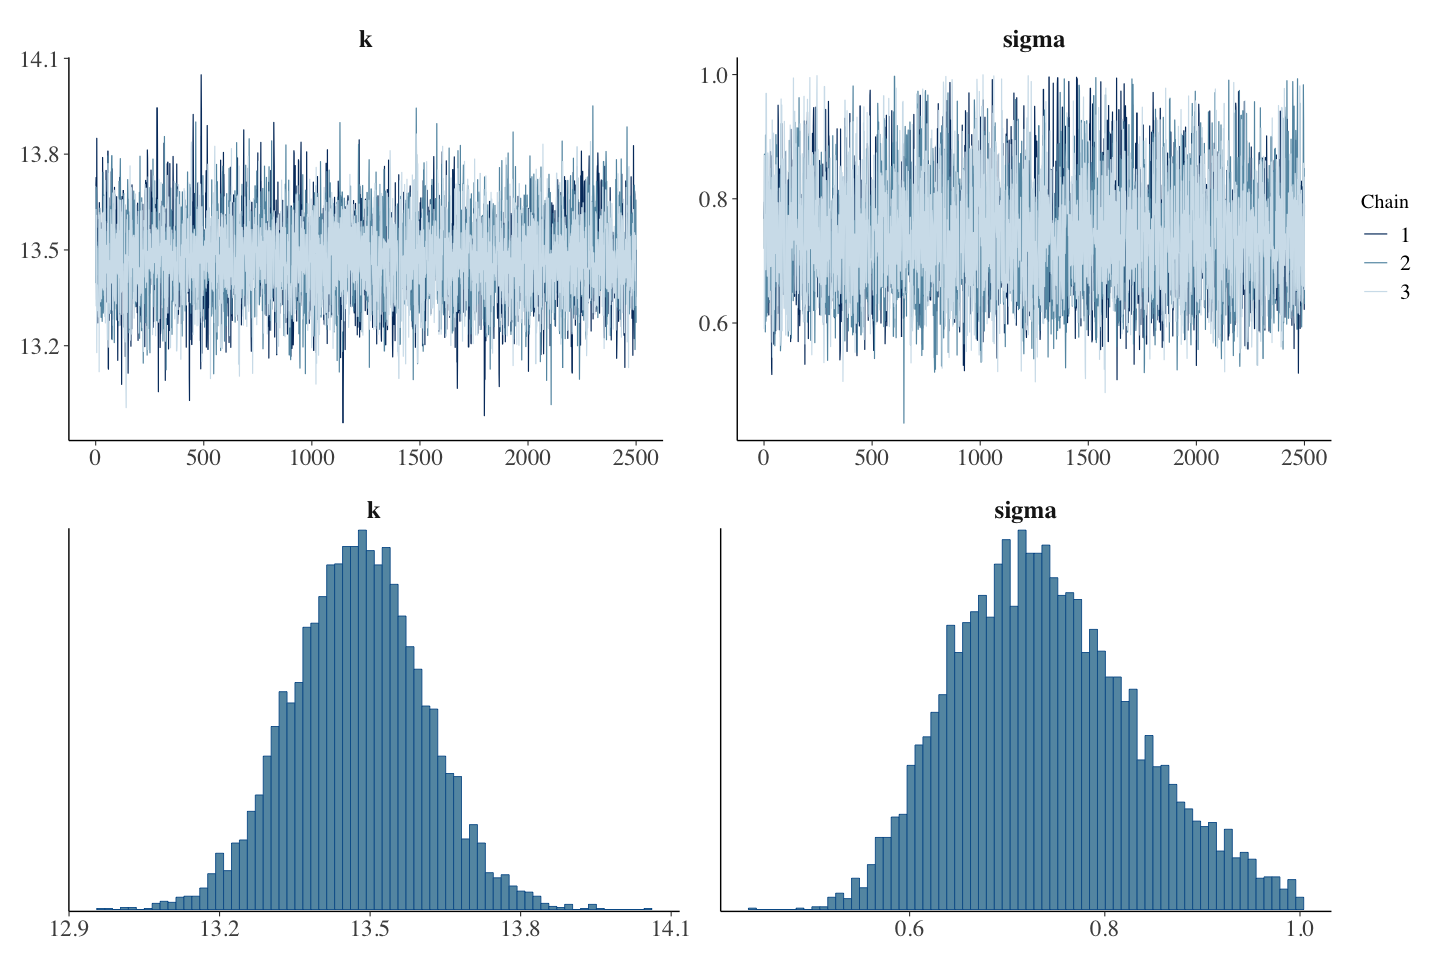

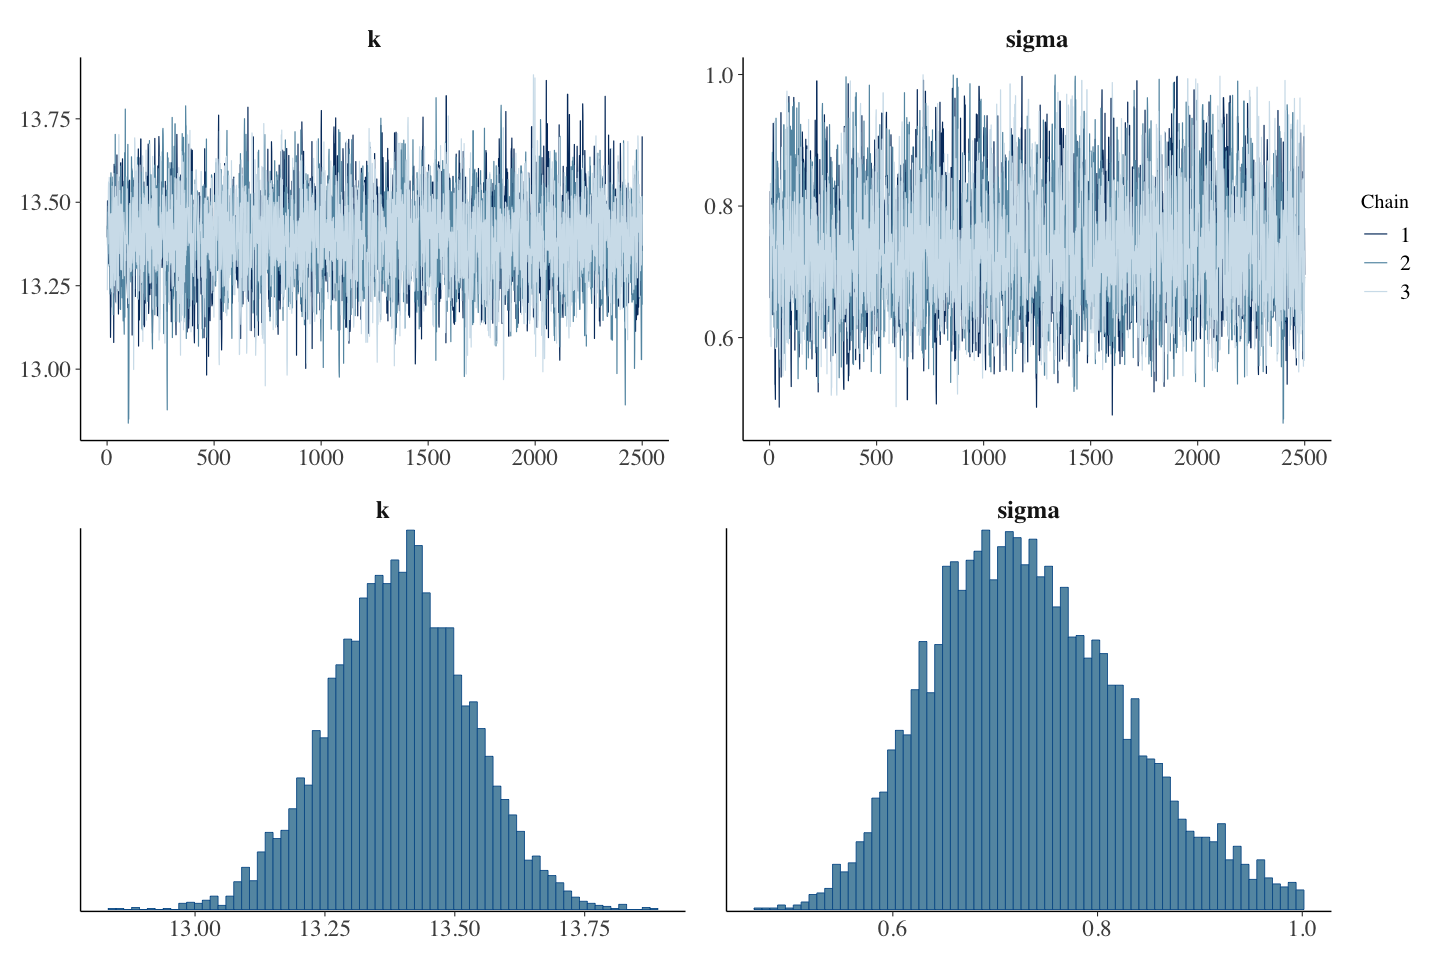

In [15]:
iterations <- 5e3
const_best_val <- stan_regression('const', iterations, warmup=iterations/2, n_chains=3)

In [16]:
cat("Best values of parameters for Bayesian linear model:, \n")
print(as.data.frame(linear_best_val))
cat('\n\n')
cat("Best values of parameters for constant model:, \n")
print(as.data.frame(const_best_val))

Best values of parameters for Bayesian linear model:, 
           Auronzo Porto_Tolle_._Pradon  Roverchiara Castelfranco_Veneto
a     6.2895849695          5.970125121  5.931387059         6.423663155
b     0.0005136243          0.004058639  0.003756461         0.003472487
sigma 0.5658386062          0.640182469  0.716697883         0.714555881
lp__  1.6316991190         -2.318335205 -5.566668051        -5.433181119


Best values of parameters for constant model:, 
        Auronzo Porto_Tolle_._Pradon Roverchiara Castelfranco_Veneto
k     7.3209126           14.1201974  13.4750817          13.3924729
sigma 0.5641847            0.6740819   0.7398623           0.7339376
lp__  2.1542082           -3.2332199  -6.0806829          -5.9451658


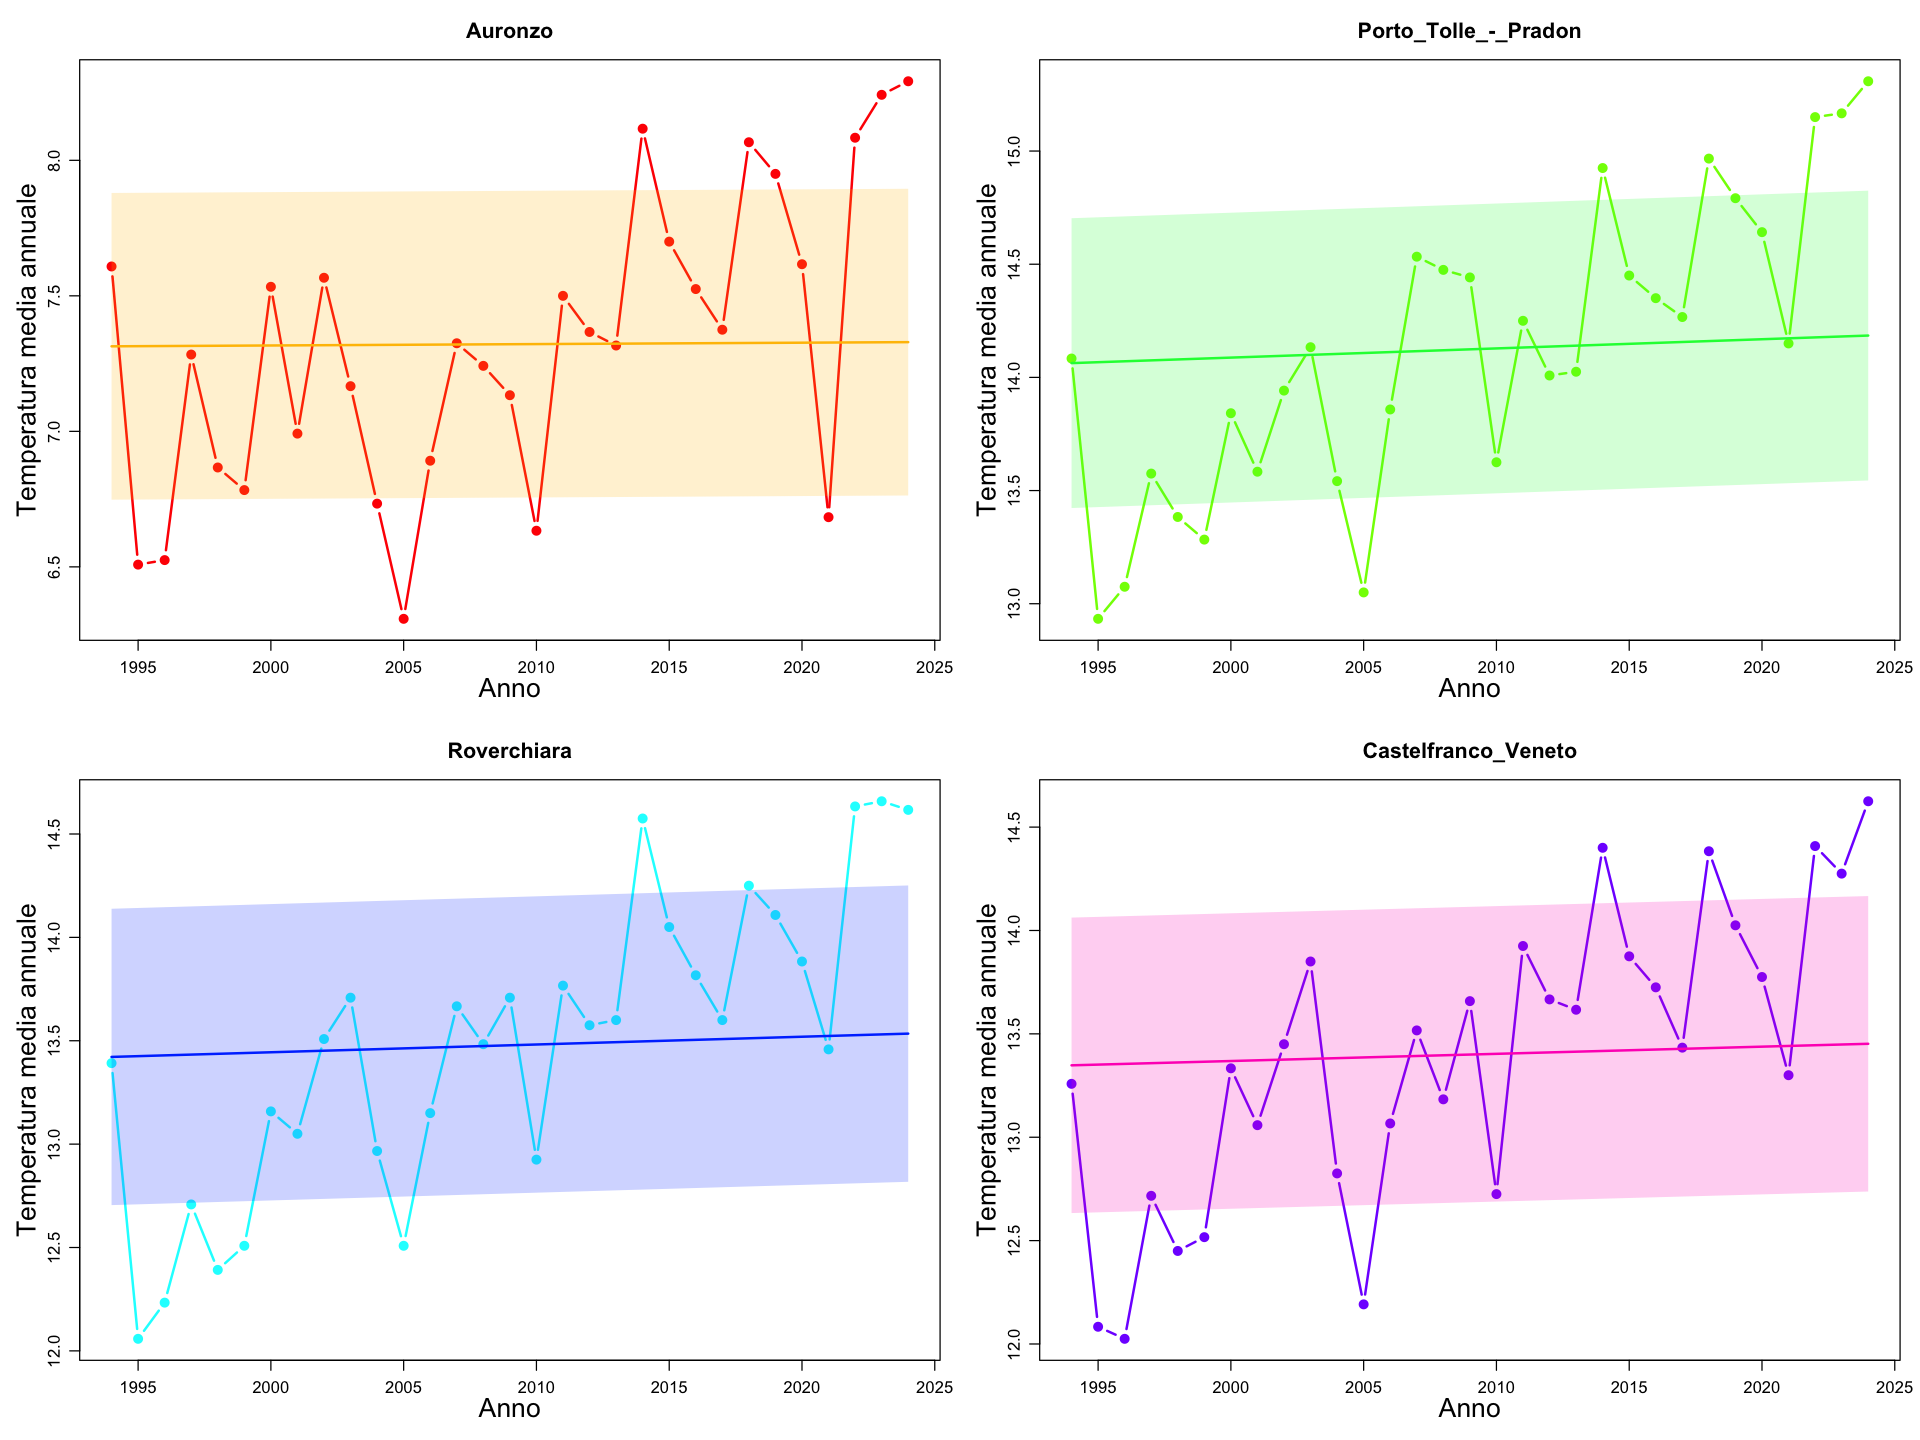

In [ ]:
options(repr.plot.width=16, repr.plot.height=12)
par(mfrow = c(2,2), bg = "white", mar=c(4,4,3,1)) 
par(mgp = c(2, 0.8, 0))

# Color palette 
colors <- rainbow(length(stations_names)*2)

for (i in 1:length(stations_names)) {
    name <- stations_names[[i]]
    annual_average <- rowMeans(dataset[[name]][["Temperatura aria a 2m (_C) media delle medie"]])
    coeffs <- linear_best_val[[name]]

    # Plot points
    plot(years, annual_average, type="b", pch=19, col=colors[2*i-1],
        lwd=2, cex.lab=1.6,
        main=name,
        font.main=2, cex.main=1.3,
        xlab="Anno", ylab="Temperatura media annuale")
    
    # Plot fitted line with error
    x_poly <- c(years, rev(years))
    y_poly <- c( years*coeffs[['b']] + coeffs[['a']] + coeffs[['sigma']], rev( years*coeffs[['b']] + coeffs[['a']] - coeffs[['sigma']]))
    rgb_col <- c(col2rgb(colors[2*i]), 0.2)
    polygon(
        x_poly, y_poly,
        col = do.call(rgb, as.list(c(col2rgb(colors[2*i]) / 255, 0.2))),
        border = NA
    )
    lines(years, years*coeffs[['b']] + coeffs[['a']], col=colors[2*i], lwd=2)
} 

## Hypothesis comparison

We perform the hypothesis comparison by computing the __Bayes factor__ $$ BF = \frac{\mathcal{L}(D, H_1)}{\mathcal{L}(D, H_2)}, $$ where $\mathcal{L}(D, H)$ is the likelihood of the data according to the hypothesis $H$. If $BF \gg 1$ we conclude that hypothesis $H_1$ is more supported by data than $H_2$. <br>
In our case
$$
\begin{align*}

\mathcal{L}(D, H_{\text{lin}}) 
&= \prod_{i=1}^N \text{Prob}(T_i | y_i, a, b, \sigma) \\
&= \prod_{i=1}^N \text{Norm}(T_i | a+b*y_i, \sigma)

\end{align*}
$$

$$
\begin{align*}

\mathcal{L}(D, H_{\text{const}}) 
&= \prod_{i=1}^N \text{Prob}(T_i| k, \sigma) \\
&= \prod_{i=1}^N \text{Norm}(T_i | k, \sigma)

\end{align*}
$$

In [22]:
likelihoods <- list()

for (name in stations_names) {
    lin_params <- linear_best_val[[name]]
    const_params <- const_best_val[[name]]
    
    likelihood <- list(const = 1, linear = 1)

    annual_average <- rowMeans(dataset[[name]][["Temperatura aria a 2m (_C) media delle medie"]])

    # Compute likelihood for both models
    likelihood$const <- prod(dnorm(annual_average, const_params[['k']], const_params[['sigma']]))
    likelihood$linear <- prod(dnorm(annual_average, lin_params[['b']]*years + lin_params[['a']], lin_params[['sigma']]))
    cat("Stazione: ", name, "\n\n")
    cat("Likelihood for linear model: ", likelihood$linear, "\n")
    cat("Likelihood for constant model: ", likelihood$const, "\n")
    cat("Bayes factor (lineare/costante): ",likelihood$linear / likelihood$const ,"\n\n\n")
}



Stazione:  Auronzo 

Likelihood for linear model:  2.25453e-11 
Likelihood for constant model:  1.971071e-11 
Bayes factor (lineare/costante):  1.14381 


Stazione:  Porto_Tolle_-_Pradon 

Likelihood for linear model:  3.942514e-13 
Likelihood for constant model:  9.101953e-14 
Bayes factor (lineare/costante):  4.331503 


Stazione:  Roverchiara 

Likelihood for linear model:  1.39492e-14 
Likelihood for constant model:  4.206216e-15 
Bayes factor (lineare/costante):  3.316329 


Stazione:  Castelfranco_Veneto 

Likelihood for linear model:  1.410778e-14 
Likelihood for constant model:  4.970027e-15 
Bayes factor (lineare/costante):  2.838571 




# Part 2

__Immagine di riferimento:__

![image](ISPRA-temperature.png)